In [460]:
using Sunny
using LinearAlgebra
using GLMakie, Plots

In [461]:
############## load cif file ##############
cif_file = joinpath(@__DIR__, "BNZS_SSL.cif")
cryst = Crystal(cif_file, symprec=1e-3)
Nd_subcryst = subcrystal(cryst, "Nd1");
# view_crystal(Nd_subcryst, 7.0)

In [472]:
############## symmetry analysis ##############
print_symmetry_table(Nd_subcryst, 8.0)
dim = (1, 1, 1)
gtensor=[2.5 2.5 0; 2.5 2.5 0; 0 0 0]
sys = System(Nd_subcryst, dim, [SpinInfo(1, S=1/2,g=gtensor)], :SUN, units=Units.meV)

Atom 1
Type 'Nd1', position [0.1708, 0.0792, 0], multiplicity 32
Allowed g-tensor: |   A  D+E    0 |
                  | D-E    B    0 |
                  |   0    0    C |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,-2] + c₂*𝒪[2,0] + c₃*𝒪[2,2] +
    c₄*𝒪[4,-4] + c₅*𝒪[4,-2] + c₆*𝒪[4,0] + c₇*𝒪[4,2] + c₈*𝒪[4,4] +
    c₉*𝒪[6,-6] + c₁₀*𝒪[6,-4] + c₁₁*𝒪[6,-2] + c₁₂*𝒪[6,0] + c₁₃*𝒪[6,2] + c₁₄*𝒪[6,4] + c₁₅*𝒪[6,6]

Bond(3, 6, [0, 0, 0])
Distance 3.5100130645547, coordination 1
Connects 'Nd1' at [0.4208, 0.1708, 0] to 'Nd1' at [0.5792, 0.3292, 0]
Allowed exchange matrix: | A  D  0 |
                         | D  B  0 |
                         | 0  0  C |

Bond(2, 3, [0, 0, 0])
Distance 4.1750642552536, coordination 2
Connects 'Nd1' at [0.6709, 0.0792, 0] to 'Nd1' at [0.4208, 0.1708, 0]
Allowed exchange matrix: |   A  D+E    0 |
                         | D-E    B    0 |
                         |   0    0    C |
Allowed DM vector: [0 0 E]

Bond(1, 3, [0, 0, 0])
Distance 4.17506425

System [SU(2)]
Cell size 32, Lattice size (1, 1, 1)


In [463]:
# print_bond(Nd_subcryst, Bond(9,10, [0, 0, 0]); b_ref=Bond(6,14,[0,0,0]))
print_bond(Nd_subcryst, Bond(3, 6, [0, 0, 0]))

Bond(3, 6, [0, 0, 0])
Distance 3.5100130645547, coordination 1
Connects 'Nd1' at [0.4208, 0.1708, 0] to 'Nd1' at [0.5792, 0.3292, 0]
Allowed exchange matrix: | A  D  0 |
                         | D  B  0 |
                         | 0  0  C |



In [464]:
############## model set up ##############
J₁ = -0.33  #true value=-0.335*2
set_exchange!(sys, [J₁  -J₁   0.0;
                   -J₁   J₁   0.0;
                    0.0  0.0  0.0], Bond(3, 6, [0, 0, 0]))

J₂ = 0.285
set_exchange!(sys,[J₂   J₂ 0.0;
                   J₂   J₂ 0.0;
                   0.0  0.0 0.0], Bond(1, 7, [0, 0, 0]))

set_exchange!(sys,[J₂   J₂ 0.0;
                   J₂   J₂ 0.0;
                   0.0  0.0 0.0], Bond(7, 10, [0, 0, 0]))
B = 2
set_external_field!(sys, (B/sqrt(2), -B/sqrt(2), 0))

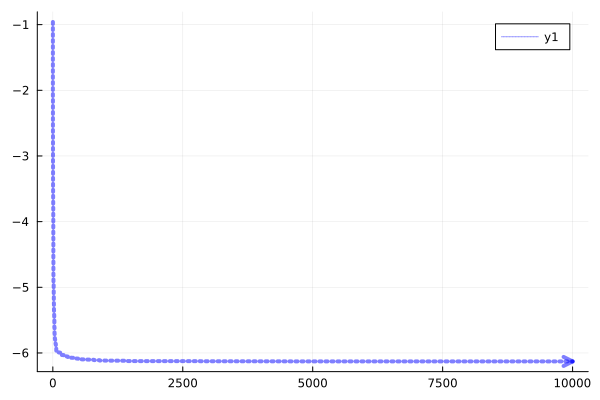

In [465]:
############## use Monte Carlo to find the ground state magnetic ordering ##############
kT = 0.0
randomize_spins!(sys)
nsweeps = 10_000
sampler = LocalSampler(kT=kT, propose=@mix_proposals 0.9 propose_uniform 0.1 propose_flip)
e=[]
n=[]
for i in 1:nsweeps
    step!(sys, sampler)
    append!(e,energy(sys))
    append!(n,i)
end
Plots.plot(n,e,line = (:steppre, :dot, :arrow, 0.5, 4, :blue))

In [466]:
################ analyze the ground state ##############
print_wrapped_intensities(sys)
suggest_magnetic_supercell([[0, 0, 0]], sys.latsize) #copy printed intensity wavevectors
sys_swt = reshape_geometry(sys, diagm(ones(Int, 3)))

Dominant wavevectors for spin sublattices:

    [0, 0, 0]             100.00% weight
Suggested magnetic supercell in multiples of lattice vectors:

    [1 0 0; 0 1 0; 0 0 1]

for wavevectors [[0, 0, 0]].


System [SU(2)]
Cell size 32, Lattice size (1, 1, 1)


In [467]:
# suggest_magnetic_supercell([[0, 0, 0],[1/2, 1/2, 0],[1/2, 0, 0],[0, 1/2, 0]], sys.latsize)
# sys_swt = reshape_geometry(sys,  [2 0 0; 0 2 0; 0 0 1])

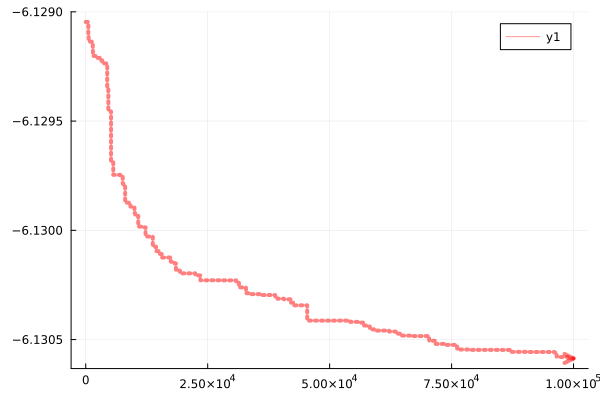

In [468]:
################ further optimize the ground state for a spin-wave system ##############
kT = 0.00
randomize_spins!(sys)
nsweeps = 100_000
sampler = LocalSampler(kT=kT, propose=@mix_proposals 0.9 propose_uniform 0.1 propose_flip)
e=[]
n=[]
for i in 1:nsweeps
    step!(sys_swt, sampler)
    append!(e,energy(sys_swt))
    append!(n,i)
end
Plots.plot(n,e,line = (:steppre, :dot, :arrow, 0.5, 4, :red))

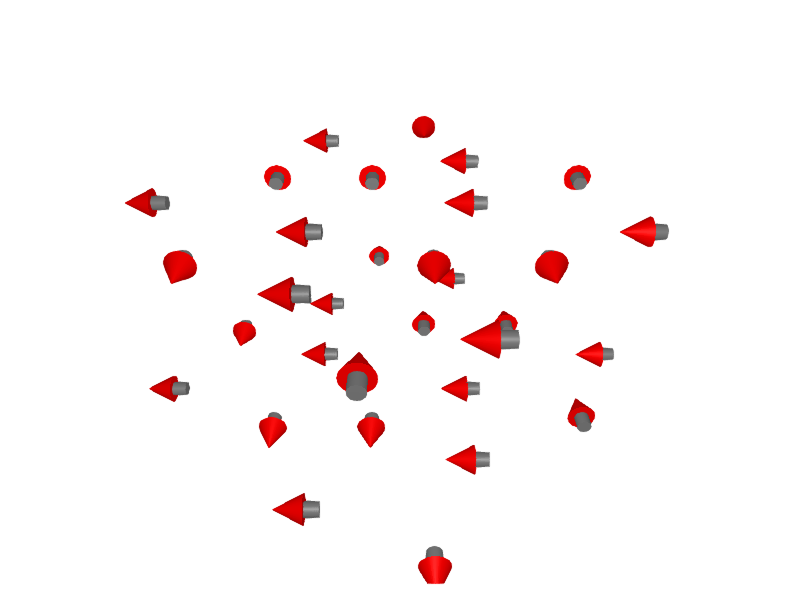

In [469]:
plot_spins(sys_swt,arrowlength=1, linewidth=0.5, arrowsize=1.0)

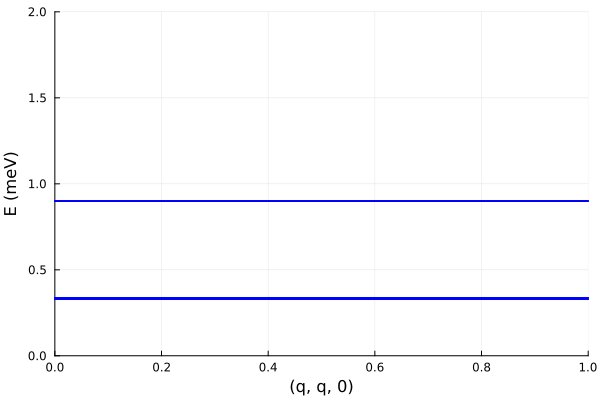

In [470]:
################ spin-wave calculations ##############
swt = SpinWaveTheory(sys_swt)
qvals = 0.0:0.005:1.0
qs = [[q, q, 0] for q in qvals]
lenq = length(qs)
numband = length(sys_swt.dipoles)
disp = dispersion(swt, qs)
energies = 0.0:0.01:2.0
kT=0.025
INS_intensities = Sunny.intensities(swt, qs, energies, 0.02)
Plots.plot(qvals, disp, linecolor="blue", label="", xlims=(0, 1), ylims=(0, 2), xlabel="(q, q, 0)", ylabel="E (meV)")

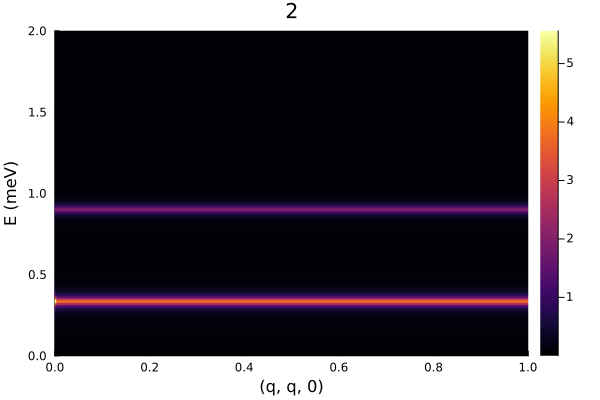

In [471]:
Plots.heatmap(qvals, energies, INS_intensities', xlims=(0, 1), ylims=(0, 2), xlabel="(q, q, 0)", ylabel="E (meV)", title=B)